## Промежуточная работа

Мы владеем сетью магазинов, в которых продаются различные товары. Наши сотрудники собрали датасет из 8523 продаж товаров в различных магазинах нашей сети. Наша задача построить модель, предсказывающую продажи каждого продукта в конкретном магазине. Используя эту модель, попробовать выявить факторы, больше всего влияющие на увеличение продаж. Описание датасета:

 - Item_Identifier	-	Id продукта
 - Item_Weight	-	Вес продукта
 - Item_Fat_Content	-	Содержание жира в продукте
 - Item_Visibility	-	%полок, отведенный под наш продукт в конкретном магазине
 - Item_Type	-	Категория продукта
 - Item_MRP	-	Максимальная цена продажи продукта
 - Outlet_Identifier	-	Идентификатор магазина
 - Outlet_Establishment_Year	-	Год открытия магазина
 - Outlet_Size	-	Площадь магазина
 - Outlet_Location_Type	-	Тип города, в котором расположен магазин
 - Outlet_Type	-	Признак является ли магазин продуктовым или супермаркетом
 - Item_Outlet_Sales	-	Продажи продукта в конкретном магазине. Именно ее и надо предсказывать

В результате работы должен получиться:
- Jupyter-ноутбук с моделью
- Признаки, влияющие больше всего на уровень продаж
- Датасет, если после ваших манипуляций он отличается от исходного;
- Документ с обоснованием решения и краткими результатами: какие техники и почему использовали, что получили, что можно улучшить (можно в рамках jupyter notebook’а)

Критерии оценки:

Баллы	Что надо сделать
 - 10	Провести EDA
 - 10	Обработать категориальные признаки 
 - 10	Устранить пропущенные значения
 - 10	Изучить корреляцию признаков с данными о продажах
 - 10	Выбрать и обосновать метрику, на основе которой будем измерять качество полученной модели
 - 20	Построить и подобрать оптимальные параметры для любой линейной модели
 - 20	Построить и подобрать оптимальные параметры для любой нелинейной модели
 - 20	Провести стекинг нескольких моделей
 - 10	Оценить качество модели на отложенной выборке
 - 10	Выбрать топ 3 признака больше всего влияющие на объемы продаж

Все шаги решения должны сопровождаться подробным описанием полученных результатов и обоснованием выбора того или иного шага! За отсутствие описания так же будут снижаться баллы.

Максимальное доступное количество баллов - 130
Для получения зачета надо набрать минимум 80 баллов
Для получения зачета с отличием надо набрать минимум 120 баллов


#### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

%matplotlib inline

#### Загружаем датасет

In [2]:
df = pd.read_csv('data.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


#### EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


Видим, что встречаются null значения в Item_Weight, Outlet_Size

In [4]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [5]:
num_features = ['Item_Weight', 'Item_Visibility',
      'Item_MRP', 'Outlet_Establishment_Year']
cat_features = ['Item_Identifier', 'Item_Fat_Content', 
       'Item_Type', 'Outlet_Identifier',
        'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type']
target = ['Item_Outlet_Sales']

Смотрим статистику распределения количественных признаков


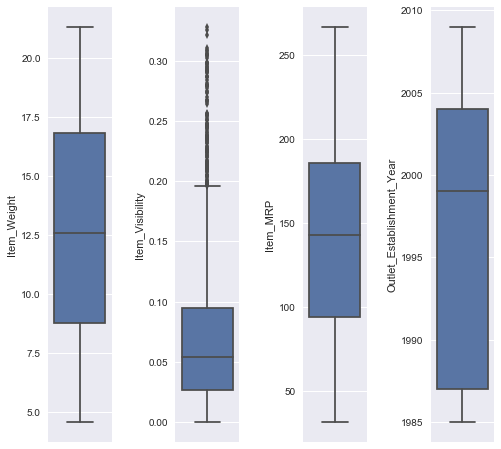

In [6]:
print('Смотрим статистику распределения количественных признаков')
fig, axes = plt.subplots(1, 4, figsize=(8, 8))
for i, feature in enumerate(num_features):
    sns.boxplot( y = feature, data = df, ax= axes[i])
plt.subplots_adjust(wspace=1, hspace=1)

В Item_Visibility видим большое количество выбросов.

In [7]:
print('Кол-во уникальных товаров')
len(df.Item_Identifier.unique())

Кол-во уникальных товаров


1559

In [8]:
print('Кол-во уникальных групп товаров')
len(df.Item_Type.unique())

Кол-во уникальных групп товаров


16

In [9]:
print('Кол-во уникальных товаров по группам')
df.groupby(['Item_Type'])['Item_Identifier'].nunique()

Кол-во уникальных товаров по группам


Item_Type
Baking Goods             119
Breads                    45
Breakfast                 20
Canned                   120
Dairy                    125
Frozen Foods             155
Fruits and Vegetables    220
Hard Drinks               40
Health and Hygiene        95
Household                170
Meat                      80
Others                    30
Seafood                   10
Snack Foods              220
Soft Drinks               80
Starchy Foods             30
Name: Item_Identifier, dtype: int64

Из id продуктов, делаю предположение, что первые две буквы обозначают тип продукта, FD - food, DR - drink и т.д.
Разделим на два столбца

In [10]:
df['Item_Group'] = df['Item_Identifier'].str[:2]
df['Item'] = df['Item_Identifier'].str[2:]
df = df.drop('Item_Identifier', axis = 1)

Как зависит объем продаж от размера магазинов
Не совсем очевидная статистика, у Medium магазинов медиана и диапазон 2-3 квартилей больше, чем у High


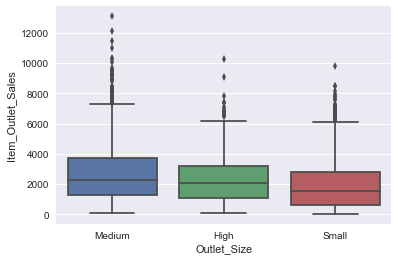

In [11]:
print('Как зависит объем продаж от размера магазинов')
print('Не совсем очевидная статистика, у Medium магазинов медиана и диапазон 2-3 квартилей больше, чем у High')
sns.boxplot(x = 'Outlet_Size', y ='Item_Outlet_Sales', data = df)

Как зависит объем продаж от типа магазина


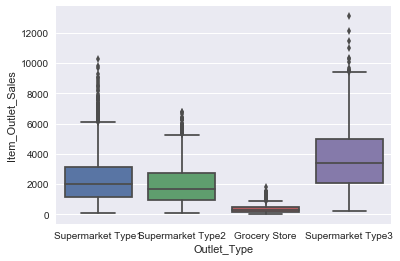

In [12]:
print('Как зависит объем продаж от типа магазина')
sns.boxplot(x = 'Outlet_Type', y ='Item_Outlet_Sales', data = df)

Как зависит объем продаж от типа города
Длz Tier 2 характеры большее дорогие покупки, а для Tier 1 более дешевые


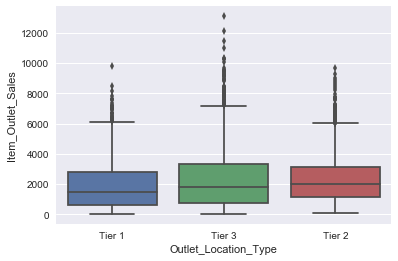

In [13]:
print('Как зависит объем продаж от типа города')
print('Длz Tier 2 характеры большее дорогие покупки, а для Tier 1 более дешевые')
sns.boxplot(x = 'Outlet_Location_Type', y ='Item_Outlet_Sales', data = df)

Как зависит объем продаж от категории товара
Тут явных признаков различия нет


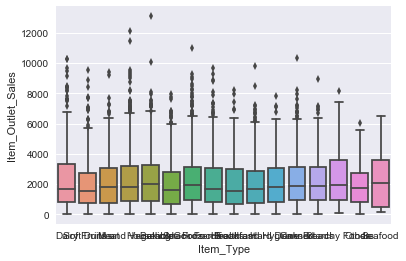

In [14]:
print('Как зависит объем продаж от категории товара')
print('Тут явных признаков различия нет')
sns.boxplot(x = 'Item_Type', y ='Item_Outlet_Sales', data = df)

#### Заполним пропущенные значения

Восстановим вес продукта по среднему значению в категории этого товара

In [15]:
for i in df.Item_Type.unique():
    df.Item_Weight[df.Item_Type == i] = df.Item_Weight[df.Item_Type == i].fillna(df.Item_Weight[df.Item_Type == i].mean())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 13 columns):
Item_Weight                  8523 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
Item_Group                   8523 non-null object
Item                         8523 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 865.7+ KB


Посмотрим варианты размера магазина

In [17]:
df.Outlet_Size.unique()

array(['Medium', nan, 'High', 'Small'], dtype=object)

Смотрим распределение размеров по типу магазина. Гипотеза - для определенных типов испльзуются определенные площади

In [18]:
df.groupby(['Outlet_Type','Outlet_Size'])['Outlet_Identifier'].nunique()

Outlet_Type        Outlet_Size
Grocery Store      Small          1
Supermarket Type1  High           1
                   Medium         1
                   Small          2
Supermarket Type2  Medium         1
Supermarket Type3  Medium         1
Name: Outlet_Identifier, dtype: int64

In [19]:
df[df.Outlet_Size.isnull()].groupby('Outlet_Type')['Outlet_Identifier'].nunique()

Outlet_Type
Grocery Store        1
Supermarket Type1    2
Name: Outlet_Identifier, dtype: int64

Для Grocery Store  поставим значение Small

In [20]:
df.Outlet_Size[(df.Outlet_Size.isnull())
               &(df.Outlet_Type == 'Grocery Store')] = df.Outlet_Size[(df.Outlet_Size.isnull())
                                                                      &(df.Outlet_Type == 'Grocery Store')].fillna('Small')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Для Supermarket Type1 с NULL Значениями обучим модель после обра отки категориальных признаков

#### Категориальные признаки

Преобразуем размер магазина 

In [21]:
le = LabelEncoder()
df.Outlet_Size[~df.Outlet_Size.isnull()] = le.fit_transform(df.Outlet_Size[~df.Outlet_Size.isnull()])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
df['Outlet_Establishment_Year'] = df['Outlet_Establishment_Year'].apply(str)

Преобразовываем все категориальные признаки в стобцы на каждое уникальное значения

In [23]:
#Item пока просто удалим, т.к. разворачивать в категориальные признаки создаст большую матрицу
cat_dummies = pd.get_dummies(df[['Item_Fat_Content','Item_Type','Outlet_Identifier','Outlet_Establishment_Year'
                        ,'Outlet_Location_Type','Outlet_Type','Item_Group']], prefix='cat_')
df = pd.concat([df,cat_dummies], axis = 1)
df = df.drop(['Item_Fat_Content','Item_Type','Outlet_Establishment_Year','Outlet_Identifier'
                        ,'Outlet_Location_Type','Outlet_Type','Item_Group','Item'], axis = 1)

In [24]:
df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Size,Item_Outlet_Sales,cat__LF,cat__Low Fat,cat__Regular,cat__low fat,cat__reg,...,cat__Tier 1,cat__Tier 2,cat__Tier 3,cat__Grocery Store,cat__Supermarket Type1,cat__Supermarket Type2,cat__Supermarket Type3,cat__DR,cat__FD,cat__NC
0,9.30,0.016047,249.8092,1,3735.1380,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
1,5.92,0.019278,48.2692,1,443.4228,0,0,1,0,0,...,0,0,1,0,0,1,0,1,0,0
2,17.50,0.016760,141.6180,1,2097.2700,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
3,19.20,0.000000,182.0950,2,732.3800,0,0,1,0,0,...,0,0,1,1,0,0,0,0,1,0
4,8.93,0.000000,53.8614,0,994.7052,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,1


Ищем лучшие параметры и обучаем модель для предсказания размера магазина

In [25]:
X_size = df[(df['cat__Supermarket Type1'] == 1)&(~df['Outlet_Size'].isnull())]
y_size = X_size.Outlet_Size.astype('int')
X_size = X_size.drop('Outlet_Size', axis= 1)
X_target = df[(df['cat__Supermarket Type1'] == 1)&(df['Outlet_Size'].isnull())]
X_target = X_target.drop('Outlet_Size', axis= 1)

In [26]:
dt_model = DecisionTreeClassifier()
parameters={'criterion':['gini','entropy'], 'min_samples_split' : range(2,20,1),'max_depth': range(1,15,1)}
grid = GridSearchCV(dt_model,parameters, cv = 5)
grid.fit(X_size, y_size)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'min_samples_split': range(2, 20), 'max_depth': range(1, 15)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [27]:
grid.best_params_

{'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 2}

In [28]:
dt_model = DecisionTreeClassifier(**grid.best_params_)
dt_model.fit(X_size, y_size)
prediction = dt_model.predict(X_target)
df['Outlet_Size'][(df['cat__Supermarket Type1'] == 1)&(df['Outlet_Size'].isnull())] = prediction

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 55 columns):
Item_Weight                   8523 non-null float64
Item_Visibility               8523 non-null float64
Item_MRP                      8523 non-null float64
Outlet_Size                   8523 non-null object
Item_Outlet_Sales             8523 non-null float64
cat__LF                       8523 non-null uint8
cat__Low Fat                  8523 non-null uint8
cat__Regular                  8523 non-null uint8
cat__low fat                  8523 non-null uint8
cat__reg                      8523 non-null uint8
cat__Baking Goods             8523 non-null uint8
cat__Breads                   8523 non-null uint8
cat__Breakfast                8523 non-null uint8
cat__Canned                   8523 non-null uint8
cat__Dairy                    8523 non-null uint8
cat__Frozen Foods             8523 non-null uint8
cat__Fruits and Vegetables    8523 non-null uint8
cat__Hard Drinks              8523

Преобразуем последний категориальный признак размера магазина

In [30]:
cat_dummies = pd.get_dummies(df[['Outlet_Size']], prefix='cat_Size_')
df = pd.concat([df,cat_dummies], axis = 1)
df = df.drop(['Outlet_Size'], axis = 1)

In [31]:
df.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,cat__LF,cat__Low Fat,cat__Regular,cat__low fat,cat__reg,cat__Baking Goods,...,cat__Grocery Store,cat__Supermarket Type1,cat__Supermarket Type2,cat__Supermarket Type3,cat__DR,cat__FD,cat__NC,cat_Size__0,cat_Size__1,cat_Size__2
0,9.30,0.016047,249.8092,3735.1380,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
1,5.92,0.019278,48.2692,443.4228,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0
2,17.50,0.016760,141.6180,2097.2700,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
3,19.20,0.000000,182.0950,732.3800,0,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,1
4,8.93,0.000000,53.8614,994.7052,0,1,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0


#### Корреляция признаков с данными о продажах

In [32]:
corr = []
for i in df.columns:
    correl = df.corr().loc[i,'Item_Outlet_Sales']
    corr.append([i,correl])
    
corr = pd.DataFrame(corr, columns=['feature','corr_coef'])
print(corr.sort_values(by= 'corr_coef').head())
print(corr.sort_values(by= 'corr_coef', ascending=False).head(6))

               feature  corr_coef
47  cat__Grocery Store  -0.411727
38           cat__1998  -0.284883
25         cat__OUT010  -0.284883
29         cat__OUT019  -0.277250
56         cat_Size__2  -0.208912
                   feature  corr_coef
3        Item_Outlet_Sales   1.000000
2                 Item_MRP   0.567574
50  cat__Supermarket Type3   0.311192
30             cat__OUT027   0.311192
55             cat_Size__1   0.204701
48  cat__Supermarket Type1   0.108765


Сильно коррелируют отдельные магазины, их размеры, типы и максимальная цена продажи в них

#### Делим выборку на обучающую и тестовую

In [33]:
y = df.Item_Outlet_Sales
X = df.drop('Item_Outlet_Sales', axis= 1)
features = X.columns

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

#### Нормализуем данные для обучения

In [35]:
stsc = StandardScaler()
X_train = pd.DataFrame(stsc.fit_transform(X_train))
X_test = pd.DataFrame(stsc.transform(X_test))

#### Выбрать и обосновать метрику, на основе которой будем измерять качество полученной модели

In [36]:
from sklearn.metrics import r2_score

В качестве метрики выбрал коффициент детерминации, а не MSE, чтобы исключить сильные штрафы из-за выбросов и понимать, насколько хорошо модель решает задачу, что MSE также не позволяет сделать.

#### Построить и подобрать оптимальные параметры для любой линейной модели

In [37]:
model = LinearRegression()
parameters = {'fit_intercept':[True,False], 
              'normalize':[True,False], 
              'copy_X':[True, False]}
grid = GridSearchCV(model, parameters, cv=5)
grid.fit(X_train,y_train)
print("r2 / variance : ", grid.best_score_)

r2 / variance :  0.557946748354


In [38]:
new_model = LinearRegression(**grid.best_params_)
new_model.fit(X_train, y_train)
prediction = new_model.predict(X_test)
print("r2 / variance : ", r2_score(y_test, prediction))

r2 / variance :  0.566981226621


#### Построить и подобрать оптимальные параметры для любой нелинейной модели

In [39]:
model = DecisionTreeRegressor()
parameters = {'min_samples_split' : range(2,20,1),'max_depth': range(1,15,1)}
grid = GridSearchCV(model, parameters, cv=5)
grid.fit(X_train,y_train)
print("r2 / variance : ", grid.best_score_)

r2 / variance :  0.586710932854


In [40]:
new_model = DecisionTreeRegressor(**grid.best_params_)
new_model.fit(X_train, y_train)
prediction = new_model.predict(X_test)
print("r2 / variance : ", r2_score(y_test, prediction))

r2 / variance :  0.594094846017


Топ 3 признака больше всего влияющие на объемы продаж

In [41]:
importances = new_model.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(0,3):
    print("%d. feature %s with value (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

1. feature Item_MRP with value (0.557669)
2. feature cat__Grocery Store with value (0.322252)
3. feature cat__1985 with value (0.115297)


#### Провести стекинг нескольких моделей

In [42]:
y_train_int = y_train.astype(int)

In [43]:
def get_meta_features(clf, X_train, y_train, X_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        model.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = model.predict(X_train.iloc[test_ind])
        meta_test += model.predict(X_test) 
    print('Done')
    return(meta_train, meta_test/ stack_cv.n_splits)

In [50]:
stack_cv = StratifiedKFold(n_splits= 10, random_state= 777)

meta_train = []
meta_test = []
col_names = []


print('GradientBoostingRegressor fiting')
grb = SGDRegressor()
meta_tr, meta_te = get_meta_features( grb, X_train, y_train_int, X_test, stack_cv)
meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('grb_pred')

print('DecisionTreeRegressor fiting')
dtr = DecisionTreeRegressor()
meta_tr, meta_te = get_meta_features( dtr, X_train, y_train_int, X_test, stack_cv)
meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('dtr_pred')

print('KNeighborsRegressor fiting')
knreg = KNeighborsRegressor(n_neighbors=3)
meta_tr, meta_te = get_meta_features( knreg, X_train, y_train_int, X_test, stack_cv)
meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('knreg_pred')


GradientBoostingRegressor fiting


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Done
DecisionTreeRegressor fiting
Done
KNeighborsRegressor fiting
Done


In [51]:
X_meta_train = pd.DataFrame(np.stack(meta_train, axis = 1), columns= col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis = 1), columns= col_names)

In [52]:
X_meta_train = pd.DataFrame(stsc.fit_transform(X_meta_train))
X_meta_test = stsc.transform(X_meta_test)

#### Оцениваем качество модели на отложенной выборке

In [53]:
meta_model = GradientBoostingRegressor().fit(X_meta_train, y_train)
y_prediction = meta_model.predict(X_meta_test)
r2_score(y_test, y_prediction)

0.44404531982634021

In [54]:
grb.fit(X_train, y_train)
grb.score(X_test, y_test)

0.56484282010867992

#### Топ 3 признака больше всего влияющие на объемы продаж

In [55]:
importances = meta_model.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(0,3):
    print("%d. feature %s with value (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

1. feature Item_MRP with value (0.388636)
2. feature Item_Visibility with value (0.333020)
3. feature Item_Weight with value (0.278344)


В итоге мы получаем среднего качества модель. Обработать категориальные признаки не достаточно, для успешного решения задачи.
Из возможных улучшений - добавить признаки конкретных продуктов, сейчас их в модели нет, вычислительной мощности не хватает для обработки матрицы и обучения моделей через gridsearch. Также необходимо в стекинг добавить подбор параметров для каждой модели, возможно вынести в отдельную функцию. На текущем уровне стекинг дает результат хуже просто градиентного бустинга.